In [20]:
import re
import gensim
from gensim.parsing.preprocessing import strip_punctuation, strip_short, strip_numeric, strip_multiple_whitespaces, remove_stopwords
from gensim.models.word2vec import LineSentence
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
import urllib.request
import zipfile
import lzma
import shutil
import matplotlib.pyplot as plt

In [2]:
import logging
logging.basicConfig(level=logging.INFO, force = True)
logger = logging.getLogger()
logger.info("Logging initialized")

INFO:root:Logging initialized


In [3]:
#Link found here: https://metatext.io/datasets/cc100-belarusian
urllib.request.urlretrieve('https://data.statmt.org/cc-100/be.txt.xz', 
                           'be.txt.xz')

urllib.request.urlretrieve('https://github.com/Belarus/GrammarDB/archive/refs/tags/PUBLICATION_2021.zip', 
                           'GrammarDB.zip')

('GrammarDB.zip', <http.client.HTTPMessage at 0x177027c90>)

In [4]:
with lzma.open("be.txt.xz", "rb") as fsrc:
    with open("be.txt", "wb") as fdst:
        shutil.copyfileobj(fsrc, fdst)

with zipfile.ZipFile('GrammarDB.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [5]:
import xml.dom.minidom
from itertools import islice

def calculate_mapping_from_forms_to_base(filepath, tag_prefix=""):
    xml_doc = xml.dom.minidom.parse(filepath)
    paradigms = xml_doc.getElementsByTagName('Paradigm')
    result = {}
    collision_count = 0
    collisions = set()
    for paradigm in paradigms:
        tag = paradigm.getAttribute('tag')
        if tag.startswith(tag_prefix):
            variants = paradigm.getElementsByTagName('Variant')
            for variant in variants:
                base = variant.getAttribute('lemma').replace("+", "").lower()
                forms = variant.getElementsByTagName('Form')
                local_map = {}
                citation_count = max([form.getAttribute('slouniki').count(',') for form in forms]) + 1
                for form in forms:
                    if len(form.childNodes) > 0:
                        word = form.childNodes[0].data.replace("+", "").lower()
                        local_map[word] = (base, citation_count)
                for k, v in local_map.items():
                    if k in result:
                        if result[k][1] == v[1] and result[k][0] != v[0]:
                            collision_count += 1
                            collisions.add(v[0])
                            collisions.add(result[k][0])
                        elif result[k][1] < v[1]:
                            result[k] = v
                    else:
                        result[k] = v
                    
    logger.info(f"Collisions (forms leading to different base word, and having same amount of citation): {collision_count}")
    logger.info(f"Examples of collisions: {list(islice(collisions, 5))}")
    for k in result:
        result[k] = result[k][0]
    return result

In [6]:
#verbs
v = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/V.xml')

#proper nouns
np = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/NP.xml', 'NPII')

#nouns
n1 = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/N1.xml')
n2 = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/N2.xml')
n3 = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/N3.xml')

#adjectives
adj1 = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/A1.xml')
adj2 = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/A2.xml')

WORD_MAP = {}
WORD_MAP.update(v)
WORD_MAP.update(np)
WORD_MAP.update(n1)
WORD_MAP.update(n2)
WORD_MAP.update(n3)
WORD_MAP.update(adj1)
WORD_MAP.update(adj2)

INFO:root:Collisions (forms leading to different base word, and having same amount of citation): 2597
INFO:root:Examples of collisions: ['зацыкліць', 'пераўшчыльняць', 'збядніць', 'адурняць', 'апастыляць']
INFO:root:Collisions (forms leading to different base word, and having same amount of citation): 33
INFO:root:Examples of collisions: ['палестына', 'мачулішчы', 'полацк', 'герцагавіна', 'палесціна']
INFO:root:Collisions (forms leading to different base word, and having same amount of citation): 1345
INFO:root:Examples of collisions: ['залогадаўца', 'абісінец', 'барэц', 'бесхацінка', 'духі']
INFO:root:Collisions (forms leading to different base word, and having same amount of citation): 1155
INFO:root:Examples of collisions: ['ком', 'паля', 'пацярпелая', 'канвой', 'містык']
INFO:root:Collisions (forms leading to different base word, and having same amount of citation): 954
INFO:root:Examples of collisions: ['разлог', 'самец', 'хіндустанка', 'туш', 'цеплатэхніка']
INFO:root:Collisions 

In [7]:
print(len(WORD_MAP))

2272218


In [8]:
print(WORD_MAP['рухам'])
print(WORD_MAP['беларусі'])

рух
беларусь


In [9]:
def strip_trailing_newline(iterable):
    for i in iterable:
        yield i.rstrip()

CHARACTERS_MAP = {'ý': 'ў', 'i': 'і', 'ньн': 'нн', 'цьц': 'цц', 'сьц': 'сц', 'сьл':'сл', 'дзьдз': 'ддз', ' ў': 'у'}
def replace_characters(iterable):
    for s in iterable:
        for k, v in CHARACTERS_MAP.items():
            s = s.replace(k, v)
        yield s

def split_sentences(iterable):
    for i in iterable:
        merged_dots = re.sub("[\.]+", ".", i)
        sentences = merged_dots.split('.')
        for s in sentences:
            yield s

STOPWORDS = ['на', 'не', 'што', 'да', 'па', 'як', 'за', 'для', 'гэта', 'ад', 'але', 'калі', 'пра', 'у', 'яго', 'якія', 'ён', 'іх', 'мы', 'каб', 'толькі', 'аб', 'таксама', 'які', 'ці', 'быў', 'было', 'яны', 'так', 'вы', 'яе', 'будзе', 'пры', 'яшчэ', 'тым', 'таму', 'вельмі', 'былі', 'можна', 'яна', 'пасля', 'пад', 'можа', 'дзе', 'якая', 'тут', 'была', 'трэба', 'тое', 'таго', 'або', 'гэтым', 'бо', 'ўсё', 'хто', 'ня', 'нас', 'гэтага', 'быць', 'гэты', 'ёсць', 'праз', 'ўжо', 'са', 'нават', 'то', 'мяне', 'ім','ва', 'той', 'усе', 'без', 'чым', 'мне', 'мае', 'сябе', 'гэтай', 'там', 'усё', 'вось', 'ды', 'каля', 'якіх', 'ты', 'якой', 'ўсе', 'жа', 'ужо', 'паводле', 'будуць', 'аднак', 'могуць', 'сваю', 'ні', 'сваёй', 'яму', 'свае', 'гэтыя', 'проста', 'ўсіх', 'якім', 'падчас', 'тады', 'свой', 'вас', 'паміж', 'нам', 'раз', 'сваіх', 'нашай', 'менавіта', 'перад', 'вам', 'тых','зь','такім', 'свайго', 'над', 'зараз', 'амаль', 'чаму', 'ёй', 'чынам', 'напрыклад', 'якога', 'якое', 'сваім', 'можаце', 'га', 'хоць', 'бы', 'тыя', 'такія', 'потым', 'адным', 'такі', 'якую', 'сабе','сам','гэтых','мая','наш','зусім','чаго','наша','зноў','дык','такіх','нашага','адразу','каго','самі','ст','ну','нашы','нашым','самы','яно','гэтае','дзеля','куды','by','гг']
def preprocess_sentences(iterable):
    for i in iterable:
        s = strip_multiple_whitespaces(strip_numeric(strip_short(strip_punctuation(i))))
        s = s.lower()
        s = re.sub("[«»“”„…—°′²]", "", s)
        s = remove_stopwords(s, stopwords=STOPWORDS)
        s = ' '.join([WORD_MAP[w] for w in s.split() if w in WORD_MAP])
        yield s

def remove_short_lines(iterable):
    for i in iterable:
        if not i.isspace() and len(i) >= 20:
            yield i


In [10]:
with open('be.txt', 'r') as original_file:
    with open('processed-corpus.txt', 'w') as sentences_file:
        for s in remove_short_lines(preprocess_sentences(split_sentences(replace_characters(strip_trailing_newline(original_file))))):
            sentences_file.write(s + "\n")

In [11]:
loss_list = []
class Callback(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_list.append(loss)
        logger.info('Loss after epoch {}:{}'.format(self.epoch, loss))
        model.running_training_loss = 0.0
        self.epoch = self.epoch + 1

In [16]:
model = Word2Vec(vector_size=100, window=3, min_count=10, workers=5)

INFO:gensim.utils:Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=100, alpha=0.025>', 'datetime': '2023-04-25T17:14:31.634420', 'gensim': '4.3.1', 'python': '3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 09:05:00) [Clang 14.0.6 ]', 'platform': 'macOS-12.6-x86_64-i386-64bit', 'event': 'created'}


In [17]:
sentences = LineSentence('processed-corpus.txt')

In [18]:
model.build_vocab(sentences, progress_per=5000000)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #5000000, processed 37867729 words, keeping 101012 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000000, processed 75796913 words, keeping 114270 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #15000000, processed 113650824 words, keeping 121748 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000000, processed 151518980 words, keeping 126665 word types
INFO:gensim.models.word2vec:collected 128690 word types from a corpus of 170374613 raw words and 22495632 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=10 retains 77978 unique words (60.59% of original 128690, drops 50712)', 'datetime': '2023-04-25T17:15:35.710567', 'gensim': '4.3.1', 'python':

In [19]:
#we override alpha with small values, since default values result in poor train performance. See loss plot below
model.train(sentences, epochs=100, start_alpha=0.0001, end_alpha=0.00001, total_examples=model.corpus_count, total_words=model.corpus_total_words, compute_loss=True, report_delay=300, callbacks=[Callback()])


INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'training model with 5 workers on 77978 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=3 shrink_windows=True', 'datetime': '2023-04-25T17:15:36.491245', 'gensim': '4.3.1', 'python': '3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 09:05:00) [Clang 14.0.6 ]', 'platform': 'macOS-12.6-x86_64-i386-64bit', 'event': 'train'}
INFO:gensim.models.word2vec:EPOCH 0 - PROGRESS: at 0.73% examples, 1187746 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 0: training on 170374613 raw words (166723350 effective words) took 116.6s, 1430417 effective words/s
INFO:root:Loss after epoch 0:34990456.0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 0.80% examples, 1318250 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1: training on 170374613 raw words (166723634 effective words) took 116.1s, 1435655 effective words/s
INFO:root:Loss after epoch 1:44155292.0
INFO:gensim.models.word2

INFO:gensim.models.word2vec:EPOCH 27: training on 170374613 raw words (166723307 effective words) took 116.2s, 1434713 effective words/s
INFO:root:Loss after epoch 27:37371768.0
INFO:gensim.models.word2vec:EPOCH 28 - PROGRESS: at 0.83% examples, 1362784 words/s, in_qsize 10, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 28: training on 170374613 raw words (166723926 effective words) took 115.9s, 1438260 effective words/s
INFO:root:Loss after epoch 28:37405836.0
INFO:gensim.models.word2vec:EPOCH 29 - PROGRESS: at 0.81% examples, 1335635 words/s, in_qsize 10, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 29: training on 170374613 raw words (166723381 effective words) took 124.8s, 1336115 effective words/s
INFO:root:Loss after epoch 29:37312652.0
INFO:gensim.models.word2vec:EPOCH 30 - PROGRESS: at 0.74% examples, 1223069 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 30: training on 170374613 raw words (166724245 effective words) took 117.2s, 1422669 effective words/s


INFO:gensim.models.word2vec:EPOCH 56 - PROGRESS: at 0.80% examples, 1328447 words/s, in_qsize 10, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 56: training on 170374613 raw words (166724372 effective words) took 115.5s, 1443721 effective words/s
INFO:root:Loss after epoch 56:36649264.0
INFO:gensim.models.word2vec:EPOCH 57 - PROGRESS: at 0.84% examples, 1393687 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 57: training on 170374613 raw words (166724703 effective words) took 115.6s, 1442438 effective words/s
INFO:root:Loss after epoch 57:36740652.0
INFO:gensim.models.word2vec:EPOCH 58 - PROGRESS: at 0.80% examples, 1323235 words/s, in_qsize 10, out_qsize 2
INFO:gensim.models.word2vec:EPOCH 58: training on 170374613 raw words (166723645 effective words) took 115.0s, 1449659 effective words/s
INFO:root:Loss after epoch 58:36722216.0
INFO:gensim.models.word2vec:EPOCH 59 - PROGRESS: at 0.82% examples, 1363583 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:

INFO:root:Loss after epoch 84:36475404.0
INFO:gensim.models.word2vec:EPOCH 85 - PROGRESS: at 0.81% examples, 1345684 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 85: training on 170374613 raw words (166724465 effective words) took 117.3s, 1421946 effective words/s
INFO:root:Loss after epoch 85:36560712.0
INFO:gensim.models.word2vec:EPOCH 86 - PROGRESS: at 0.85% examples, 1386970 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 86: training on 170374613 raw words (166721772 effective words) took 116.0s, 1437329 effective words/s
INFO:root:Loss after epoch 86:36437896.0
INFO:gensim.models.word2vec:EPOCH 87 - PROGRESS: at 0.81% examples, 1342665 words/s, in_qsize 8, out_qsize 2
INFO:gensim.models.word2vec:EPOCH 87: training on 170374613 raw words (166722549 effective words) took 117.8s, 1414893 effective words/s
INFO:root:Loss after epoch 87:36656224.0
INFO:gensim.models.word2vec:EPOCH 88 - PROGRESS: at 0.82% examples, 1356874 words/s, in_qsize 9, o

(16672317146, 17037461300)

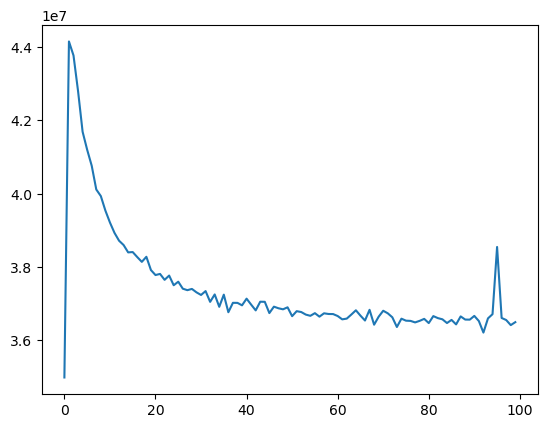

In [21]:
plt.plot(loss_list)

For comaprison, below is the loss plot when using default (larger) values for alpha. Note, that during training alpha is decreasing linearly from start value to end value. With default values in use the loss goes down near the end, once alpha gets smaller values.

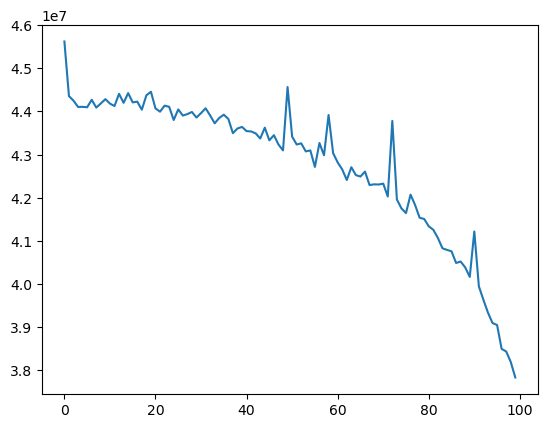

In [28]:
default_alpha_loss_list = [45621836.0, 44355904.0, 44249936.0, 44104492.0, 44107028.0, 44097436.0, 44270596.0, 44089604.0, 44185456.0, 44285424.0, 44182396.0, 44126032.0, 44408908.0, 44199988.0, 44425624.0, 44209516.0, 44227556.0, 44041368.0, 44373620.0, 44456688.0, 44070200.0, 43995008.0, 44134528.0, 44107632.0, 43802268.0, 44047244.0, 43904480.0, 43939264.0, 43987436.0, 43859148.0, 43961468.0, 44073332.0, 43907992.0, 43725336.0, 43849884.0, 43924944.0, 43826232.0, 43496588.0, 43605268.0, 43641544.0, 43543980.0, 43537204.0, 43491140.0, 43373268.0, 43624628.0, 43330720.0, 43449924.0, 43234040.0, 43097712.0, 44565932.0, 43416728.0, 43234072.0, 43260536.0, 43074152.0, 43096868.0, 42714596.0, 43268708.0, 42984456.0, 43917916.0, 43035192.0, 42818392.0, 42656488.0, 42411144.0, 42707748.0, 42523348.0, 42491780.0, 42605616.0, 42294312.0, 42310540.0, 42306532.0, 42327836.0, 42028380.0, 43780020.0, 41960848.0, 41753348.0, 41644528.0, 42072300.0, 41830796.0, 41535968.0, 41507712.0, 41336916.0, 41256888.0, 41069008.0, 40828812.0, 40791320.0, 40758012.0, 40487952.0, 40521400.0, 40385292.0, 40164828.0, 41217672.0, 39945608.0, 39633816.0, 39335348.0, 39096012.0, 39050096.0, 38497092.0, 38436708.0, 38193532.0, 37834140.0]
plt.plot(default_alpha_loss_list)

In [24]:
model.wv.most_similar('сабака', topn=20)

[('котка', 0.8813685774803162),
 ('кошка', 0.8693367838859558),
 ('кот', 0.8607653379440308),
 ('жывёліна', 0.8550747036933899),
 ('кацяня', 0.8518059253692627),
 ('пацук', 0.8364773988723755),
 ('дзік', 0.8306906223297119),
 ('сабачка', 0.8288159370422363),
 ('шчанюк', 0.8283321857452393),
 ('конь', 0.8242195248603821),
 ('муха', 0.8205313682556152),
 ('звер', 0.808570146560669),
 ('авечка', 0.8058522343635559),
 ('малпа', 0.8028984069824219),
 ('лісіца', 0.7969299554824829),
 ('брахаць', 0.7953426241874695),
 ('ведзьма', 0.7952244877815247),
 ('воўк', 0.7950000762939453),
 ('асёл', 0.7937894463539124),
 ('жаба', 0.7918252348899841)]

In [25]:
model.wv.index_to_key[:10]

['беларускі',
 'год',
 'беларусь',
 'чалавек',
 'час',
 'дзень',
 'большыць',
 'мова',
 'новы',
 'вялікі']

In [26]:
model.save("word2vec-100-bel-cc100.model")

INFO:gensim.utils:Word2Vec lifecycle event {'fname_or_handle': 'word2vec-100-bel-cc100.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-04-25T21:14:43.257452', 'gensim': '4.3.1', 'python': '3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 09:05:00) [Clang 14.0.6 ]', 'platform': 'macOS-12.6-x86_64-i386-64bit', 'event': 'saving'}
INFO:gensim.utils:not storing attribute cum_table
INFO:gensim.utils:saved word2vec-100-bel-cc100.model


In [27]:
model.wv.save_word2vec_format('word-vectors.txt')

INFO:gensim.models.keyedvectors:storing 77978x100 projection weights into word-vectors.txt
